In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU, SimpleRNN
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import cross_val_score, KFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
import keras_tuner
from joblib import dump

In [52]:
data = pd.read_csv('./data_processed.csv')

# `Record Date Discreatized` is the continuous date
# treat `Fiscal Year` and `Record Date Discretized` as numbers and standardize them
# Other data include Month and Quarter as categories
# in order to discover some trends related to a specific Quarter or Month

numeric_features = ['Fiscal Year', 'Record Date Discretized']
categorical_features = ['Electronic Category ID', 'Channel Type ID', 'Tax Category ID', 'Fiscal Quarter Number', 'Calendar Quarter Number', 'Calendar Month Number']

data = data.drop(data.columns[0], axis=1)
data = data.drop(['Calendar Year', 'Calendar Day Number'], axis=1)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
X_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X = data.drop('Net Collections Amount', axis=1)
y = data['Net Collections Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train = X_preprocessor.fit_transform(X_train)
X_test = X_preprocessor.transform(X_test)
# convert sparse matrix to numpy array
X_train = np.array(X_train.todense())
X_test = np.array(X_test.todense())

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [29]:
input_shape = (X_train.shape[1],)

# In my tests, LeakyReLU works better than normal relu
# Overfitting is very serious, maybe we can consider increasing the proportion of dropout
model = Sequential([
    Dense(128, input_shape=input_shape),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),
    
    Dense(512),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),
    
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),
    
    Dense(1)
])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.0001)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, axis=0),
                    validation_split=0.05,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=False)

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

26/26 [==============================] - 0s 890us/step - loss: 0.3566 - mae: 0.1776
Test MAE: 0.17759914696216583


3/3 [==============================] - 0s 883us/step


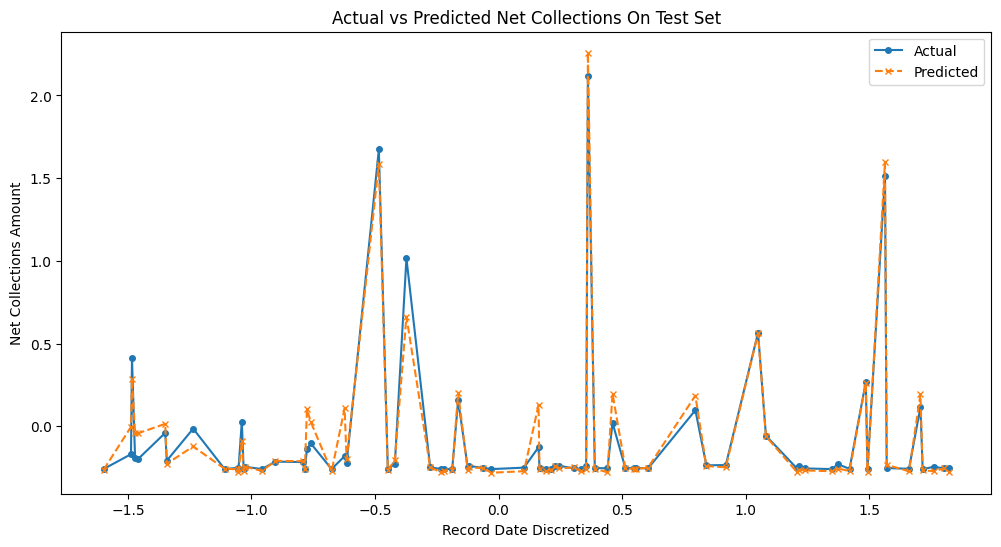

In [34]:
import matplotlib.pyplot as plt

# dump preprocessor and scaler
dump(X_preprocessor, 'model/X_preprocessor.joblib')
dump(y_scaler, 'model/y_scaler.joblib')

# Draw the predicted values and actual values of some data in the test set
SIZE = 75

yhat_test = model.predict(X_test[:SIZE])
record_dates = X_test[:SIZE, 1]

results = pd.DataFrame({
    'Record Date Discretized': record_dates,
    'Actual': y_test[:SIZE, 0],
    'Predicted': yhat_test[:SIZE, 0]
})

results_sorted = results.sort_values('Record Date Discretized')

plt.figure(figsize=(12, 6))
plt.plot(results_sorted['Record Date Discretized'], results_sorted['Actual'], label='Actual', marker='o', linestyle='-', markersize=4)
plt.plot(results_sorted['Record Date Discretized'], results_sorted['Predicted'], label='Predicted', marker='x', linestyle='--', markersize=4)

plt.title('Actual vs Predicted Net Collections On Test Set')
plt.xlabel('Record Date Discretized')
plt.ylabel('Net Collections Amount')
plt.legend()
plt.show()